<a href="https://colab.research.google.com/github/seodalzzz/Machine_Learning_implementation/blob/main/code/gmm_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import torch

np.random.seed(4242)

In [ ]:
# data generation set-up
# data : sampled from 3 Gaussians

pi_true = np.array([0.2,0.5,0.3])
mu_true = np.array([[2,2],[-1,-1],[0,-1.4]])
sigma_true = np.zeros((3,2,2))
sigma_true[0] = np.array([[1.,0.3],[0.2,0.2]])
sigma_true[1] = np.array([[0.5,0.8],[0.8,0.5]])
sigma_true[2] = np.array([[1.3,0.3],[0.2,0.4]])

colors = sns.color_palette("husl",8)
col = [colors[0],colors[1],colors[3],colors[5],colors[7]]
cols = ['b','g','r']

In [ ]:
# generate N=100 data instances

N = 100
data = np.zeros((N,3))

In [ ]:
# data generation

for i in range(N):
    z = np.random.random()
    idx = 0
    interval = 0

    for j in range(len(pi_true)):
        if z >= interval and z <= interval+pi_true[j]:
            idx = j
            break
        else:
            interval += pi_true[j]

    x, y = np.random.multivariate_normal(mu_true[idx],sigma_true[idx])
    data[i] = (x,y,idx)

<ipython-input-33-db51f16c8841>:15: RuntimeWarning: covariance is not positive-semidefinite.
  x, y = np.random.multivariate_normal(mu_true[idx],sigma_true[idx])


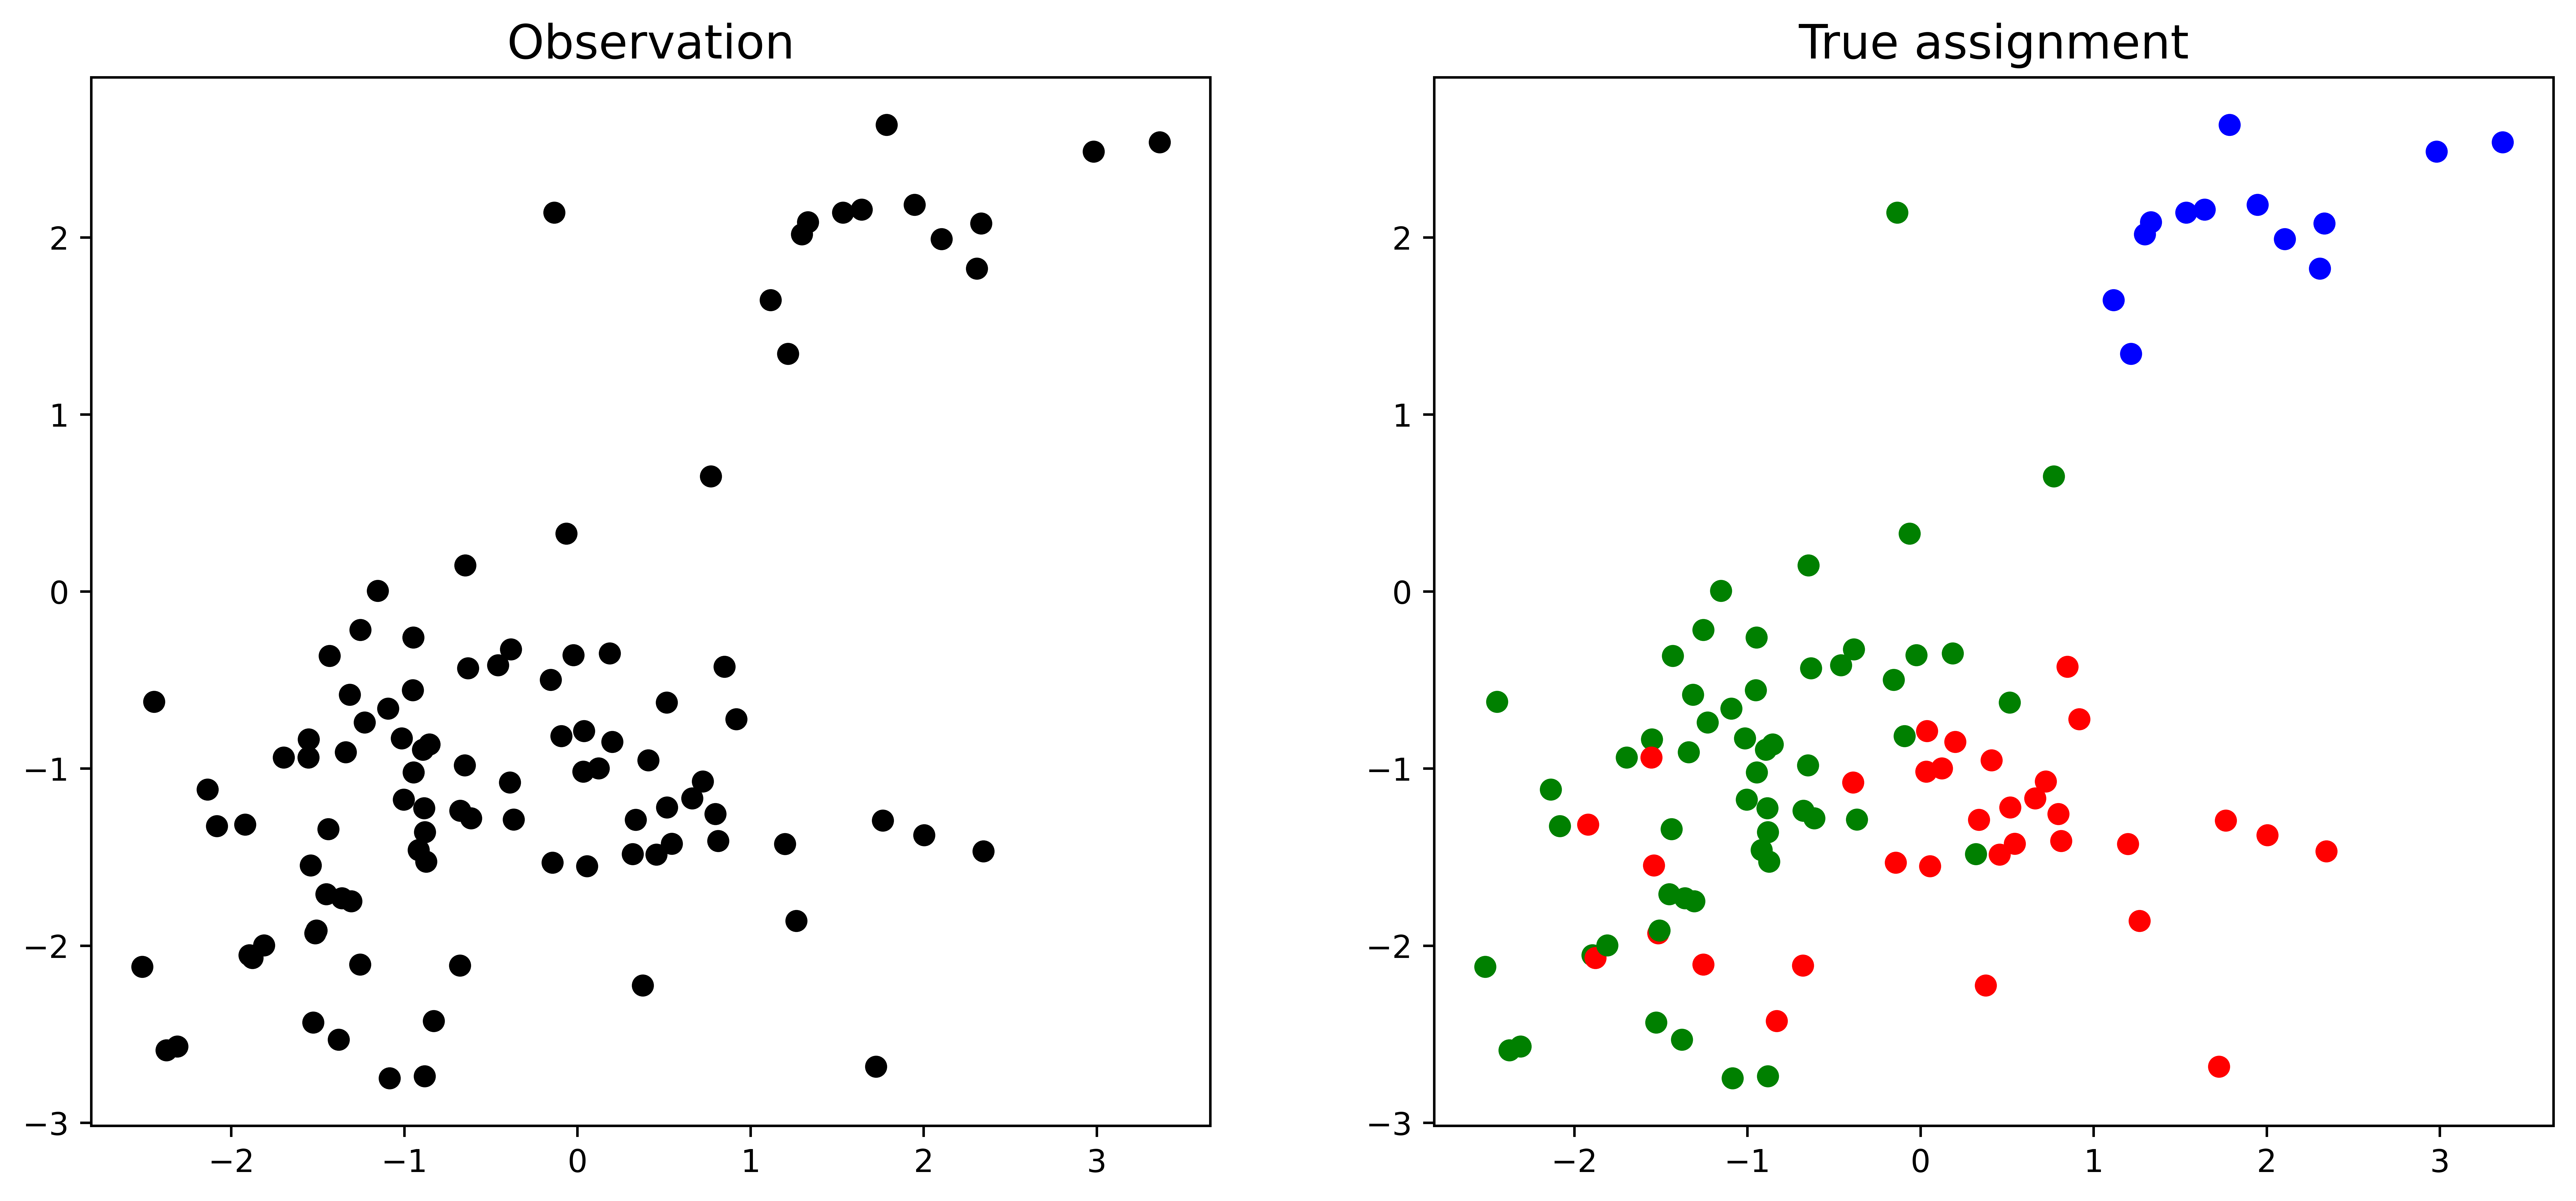

In [ ]:
# plot generated data

plt.figure(1,figsize=(14, 6),dpi=900)

plt.subplot(121)
plt.title('Observation',fontsize=15)
plt.plot(data[:,0],data[:,1],'ko')

plt.subplot(122)
plt.title('True assignment',fontsize=15)
for i in range(N):
    plt.plot(data[i,0],data[i,1],'o',c=cols[int(data[i,2])])

plt.show()

In [ ]:
# assume k=5 clusters

k = 3
itrEM = 128
showVisualization = [1,3,7,15,31,63,127]

In [ ]:
mu = np.zeros((itrEM,k,2))
sigma = np.zeros((itrEM,k,2,2))
pi = np.zeros((itrEM,k))
likelihood = np.zeros(itrEM-1)
assignment = np.zeros((N,k))

In [ ]:
mu[0,0]=[1,2]

In [ ]:
mu[0]

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
# randomly intialize the Gaussian parameters and mixing coefficient
rand_idx=np.random.randint(100,size=k)

for i in range(k):
    mu[0,i] = data[rand_idx[i],:2]
    sigma[0,i] = [[1,0],[0,1]]
    pi[0,i] = 1/k

In [ ]:
plt.figure(1,figsize=(14,25),dpi=900)
plotN = 1

for i in range(1,itrEM):

    ############ E-step: update softened cluster assignments given Gaussians and mixing coefficient

    for j in range(N):
      for l in range(k):
        #P(z_nk=1|X_n)
        assignment[j,l]=(pi[i-1,l])*(multivariate_normal.pdf(data[j,:2],mu[i-1,l],sigma[i-1,l]))
      assignment[j,:]/=np.sum(assignment[j,:])

    ############ E-step ends here

    ############ M-step: update parameters mu, sigma, pi
    for l in range(k):
      for j in range(N):
        mu[i,l,0]+=assignment[j,l]*data[j,0]
        mu[i,l,1]+=assignment[j,l]*data[j,1]
      mu[i,l]/=np.sum(assignment[:,l])


    for l in range(k):
      sum1=0
      sum2=0
      for j in range(N):
        sum1+=assignment[j,l]*((data[j,0]-mu[i-1,l,0])*(data[j,0]-mu[i-1,l,0]))
        sum2+=assignment[j,l]*((data[j,1]-mu[i-1,l,1])*(data[j,1]-mu[i-1,l,1]))
      sigma[i,l]=[[sum1/np.sum(assignment[:,l]),0],[0,sum2/np.sum(assignment[:,l])]]


    for l in range(k):
      pi[i,l]=np.sum(assignment[:,l])
    pi[i,:]/=N
    ############ M-step ends here

    ############ compute (log) likelihood

    likelihood[i-1]=0

    for j in range(N):
      sumL=0

      # sum likelihood of all cluster for each data
      for l in range(k):
        sumL+=pi[i,l]*multivariate_normal.pdf(data[j,:2],mu[i,l],sigma[i,l])

      likelihood[i-1]+=np.log(sumL)

    if i in showVisualization:
        plt.subplot(len(showVisualization),2,plotN)
        plt.title('\niteration = %s'%(i),fontsize=15)
        plotN += 1

        for j in range(N):
            color_print = np.array((0.,0.,0.))
            for l in range(k):
                color_print += np.array(col[l])*assignment[j,l]

            assignment[j] /= np.sum(assignment[j])
            plt.plot(data[j,0],data[j,1],'o',markersize=7,
                     markerfacecolor=color_print,markeredgecolor='w')

        for j in range(k):
            points = np.zeros((i,2))

            for l in range(i):
                points[l] = mu[l,j]

            plt.plot(points[:,0],points[:,1],'k')
            plt.plot(points[:,0],points[:,1],'ko',markeredgecolor=col[j],markersize=7)

plt.subplot(len(showVisualization),2,plotN+1)
plt.title('final = %s'%(i),fontsize = 15)
for j in range(N):
    color_print = np.array((0.,0.,0.))
    for l in range(k):
        color_print += np.array(col[l])*assignment[j,l]

    assignment[j] /= np.sum(assignment[j])
    plt.plot(data[j,0],data[j,1],'o',markersize=7,markerfacecolor=color_print,markeredgecolor='w')
for j in range(k):
    plt.plot(mu[-1,j,0],mu[-1,j,1],'ko',markeredgecolor='k',markerfacecolor=col[j],markersize=7)

plt.subplot(len(showVisualization),2,plotN+2)
plt.title('iteration vs. Likelihood',fontsize=15)
plt.xlabel('EM Iteration',fontsize=15)
plt.ylabel('Likelihood',fontsize=15)
plt.plot(likelihood[:])

plt.show()